## From Weiyan:
1. CWOX (contrastive whole-output explanation) is an on-going project and not all details are finalized at this moment.
2. There are multiple stages of explanation for CWOX, I do believe for your project you will need the first stage, whose code is finalized.
3. There are three steps in the first stage of CWOX, I will describe then one by one next in ordering (a),(b),(c)

For your project, Nevin Mentioned two options the obtain the heatmap, one is to run the Grad-CAM with the class y_i directly, another is to run the Grad-CAM with the cluster including y_i. This notebook is to give you the idea about how to get the cluster heatmap in the second option.

I think in your project, you do not need to run (a) Generate the top-k prediction labels for an image, you can directly start from (b) to find out which cluster that y_i is in and then run (c) to generate the cluster heatmap. 
You may need write some codes for part (b) yourself. The current part (b) is to find the clustes for the top-k prediction classes, but in your project you need to determine which cluster y_i is in from the HLTM tree and find the other classes in the same cluster.

In [1]:
# Load Package
import os
import numpy as np
import torch
from torchvision import datasets, models, transforms, utils
from scipy.special import softmax
import matplotlib.pyplot as plt
from PIL import Image
from CWOX.plt_wox import imsc

In [2]:
# Load Class_labels for ImageNet
import json
class_labels = json.load(open('resources/imagenet_class_index.json', 'r'))

In [4]:
class_labels['386']

['n02504458', 'African_elephant']

In [46]:
# Load Image and Model
loader = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
img_path='eval_image//cello_guitar.jpg'
image = Image.open(img_path).convert('RGB')
image = loader(image).float()
image=torch.unsqueeze(image, 0)
model = models.resnet50(pretrained=True)
_ = model.train(False) # put model in evaluation mode

## (a) Generate the top-k prediction labels for an image first (usually we use k=5);

In [48]:
# a. Make Prediction First
y_hat = softmax(model(image).data.numpy()[0])
top_5=np.argsort(y_hat)[::-1][:5]
for i in top_5:
    print([i,class_labels[str(i)][1],y_hat[i]])

[486, 'cello', 0.8385471]
[402, 'acoustic_guitar', 0.08186305]
[420, 'banjo', 0.035941493]
[889, 'violin', 0.020674095]
[546, 'electric_guitar', 0.007782669]


 ## (b) Feed the top-k labels into the pre-obtained HLTM (hierarchical latent tree model) tree 

(the tree has already been pre-obtained by the clusing algorithm, you can visualize the tree via https://xie-lin-li.github.io/final_submit/resnet50, the resources/ResNet50.json is the JSON file to record the structure of the tree)
      
The output of this step is to obtain the clustering for the top-k labels. For this case, top-5 predicted labels [486, 402, 420, 889, 546] are feeded and then [[486, 889], [402, 420, 546]] is output, which means 486-cello,889-violin are in one cluster and the other three are in anther cluster. The Partitioning Class Labels into Confusion Clusters is done by cutting the subtree at a certain level

- Function apply_hltm is to read in the tree and define the cut_level (usually we use the last level (cut_level=0) i.e. only classes in the last slibing cluster in the HLTM tree are grouped together);
- clusterify_resnet50.get_cluster(top_5) is to feed the top labels and get the cluster_use_final - the clustering result.

(I give a paragraph for the HLTM at the end of this notebook in case you are interested on it)

In [60]:
# b. Divide the Top 5 prediction classes into Confusion Clusters using learnt HLTM

from CWOX.apply_hltm import *
clusterify_resnet50 = apply_hltm(cut_level=0,json_path="resources/ResNet50.json")
cluster_use_final= clusterify_resnet50.get_cluster(top_5)
print(cluster_use_final)

[[486, 889], [402, 420, 546]]


 ## (c) Get the cluster heatmap by Grad-CAM
    
The last step is to get the cluster heatmap. 

## Grad-CAM

In [7]:
# !pip install torchray

We use torchray which is well-designed XAI package with Grad-CAM supported. The grad_cam funtion in Torchray originally only support the explanation for ONE class, but with some simple modification, it can also give explanation a group of classes (a cluster)

In [8]:
from torchray.attribution.grad_cam import grad_cam
def BP_logP(class_use,image1,layer_use,model):
    poss=class_use
    probs = model(image1).softmax(-1)
    grad = torch.zeros_like(probs)
    poss_p = probs[0, poss]
    grad[0, poss] = poss_p / poss_p.sum()
    saliency = grad_cam(model, image1, grad, saliency_layer=layer_use,resize = True)[0,0]
    saliency=saliency.detach().cpu().numpy()
    return saliency

In [9]:
# Get heatmap for cluster [486,889]
IOX_cluster=BP_logP([486,889],image,'layer4',model)

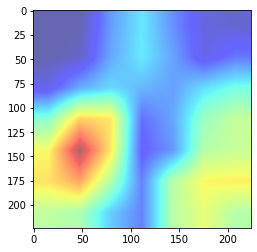

In [27]:
plt.imshow(saliency,cmap='jet', alpha=0.6)

(-0.5, 223.5, 223.5, -0.5)

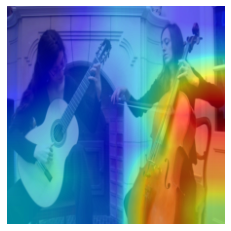

In [10]:
saliency=IOX_cluster
saliency=np.clip(saliency,a_min=0,a_max=None)
img=imsc(image[0])
plt.imshow(img)
plt.imshow(saliency, cmap='jet', alpha=0.6)
plt.axis('off')

In [28]:
plt.savefig('test.png')

<Figure size 432x288 with 0 Axes>

In [11]:
# Get heatmap for cluster [402,420,546]
IOX_cluster=BP_logP([402,420,546],image,'layer4',model)

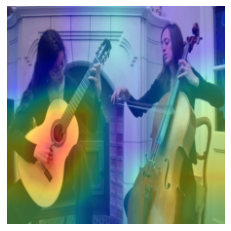

In [40]:
saliency=IOX_cluster
saliency=np.clip(saliency,a_min=0,a_max=None)
img=imsc(image[0])
plt.imshow(img)
plt.imshow(saliency, cmap='jet', alpha=0.4)
plt.axis('off')
plt.savefig('test.png')

In [13]:
## End of Code

## Details for HLTM and use HLTM to Partitioning Class Labels into Confusion Clusters 

![title](hltm1.png)
![title](hltm2.png)
![title](hltm3.png)